# Session 5: Data structuring II

### The Pandas way

*Andreas Bjerre-Nielsen*

## Motivation

Why do we want learn data analysis?

## Recap

*Which datatypes beyond numeric/boolean does pandas handle natively?*


- datetime, string, categorical, (missing)
- extensions, e.g. to spatial data with geopandas


*What can we do to missing values and duplicates?*

- missing: ignore, delete, replace (impute), collect new data
- duplicated: check whether they are present, remove, select

## Agenda

1. [joining datasets](#Joining-data)
1. [the split apply combine framework](#Split-apply-combine)
1. [reshaping data](#Reshaping-data)

## Loading the software and data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

tips = sns.load_dataset('tips')
titanic = sns.load_dataset('titanic')

We use the multi column display from Jake van der Plaas, [here](https://jakevdp.github.io/PythonDataScienceHandbook/03.07-merge-and-join.html)

In [25]:
class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)


# Joining DataFrames

Until now we've worked with one DataFrame at a time
- with the exception of `concat` in Assignment 0

We will now learn to put them together.

### Some DataFrames
Let's make some data to play with

In [26]:
left = pd.DataFrame({'key': ['A', 'B', 'C', 'D'], 'value_left': range(4)})    
right = pd.DataFrame({'key': ['C', 'D', 'E', 'F'], 'value_right': range(4,8)})
display('left', 'right')

,key,value_left
0,A,0
1,B,1
2,C,2
3,D,3
,key,value_right
0,C,4
1,D,5
2,E,6
3,F,7


## Merging data
The forthcoming figures all follow this convention:

-  <font color="blue">blue</font>: rows in merge output
-  <font color="red">red</font>: rows excluded from output (i.e., removed)
-  <font color="green">green</font>: missing values replaced with NaNs 

We use `merge` which is pandas function and a method for dataframes.

### Inner merge (default)
This merge only uses only *shared* keys

In [10]:
print(pd.merge(left, right, on='key', how='inner'))

  key  value_left  value_right
0   C           2            4
1   D           3            5


<center><img src='https://i.stack.imgur.com/YvuOa.png' alt="Drawing" style="width: 600px;"/></center>

### Left merge
This merge uses only *left* keys

In [11]:
print(pd.merge(left, right, on='key', how='left'))

  key  value_left  value_right
0   A           0          NaN
1   B           1          NaN
2   C           2          4.0
3   D           3          5.0


<center><img src='https://i.stack.imgur.com/BECid.png' alt="Drawing" style="width: 600px;"/></center>

### Right merge
This merge uses only *right* keys

In [12]:
print(pd.merge(left, right, on='key', how='right'))

  key  value_left  value_right
0   C         2.0            4
1   D         3.0            5
2   E         NaN            6
3   F         NaN            7


<center><img src='https://i.stack.imgur.com/8w1US.png' alt="Drawing" style="width: 600px;"/></center>

### Outer merge
This merge uses *all* keys

In [13]:
print(pd.merge(left, right, on='key', how='outer'))

  key  value_left  value_right
0   A         0.0          NaN
1   B         1.0          NaN
2   C         2.0          4.0
3   D         3.0          5.0
4   E         NaN          6.0
5   F         NaN          7.0


<center><img src='https://i.stack.imgur.com/euLoe.png' alt="Drawing" style="width: 600px;"/></center>

### Overview of merge types

<center><img src='https://www.dofactory.com/Images/sql/sql-joins.png' alt="Drawing" style="width: 450px;"/></center>

More merge type exists, see [this post](https://stackoverflow.com/questions/53645882/pandas-merging-101) for details.

## Joining DataFrames

We can also join by keys in the index. This is possible with `join` or `concat`:
- both methods work vertically and horizontally.
- `concat` works with  multiple DataFrames at once;

Requirement: overlapping index keys or column names.

In [14]:
df0 = left.set_index('key')
df1 = right.set_index('key')

### Horizontal join 

Works like `merge` where keys is now the index! 

In [15]:
print(df0.join(df1, how='inner'))

     value_left  value_right
key                         
C             2            4
D             3            5


### Vertical join 

`concat` on axis=0 stacks the dataframes on top of each other!

In [39]:
dfs = [df0, df1]
print(pd.concat(dfs, axis=1, sort=False))
# print(pd.concat([df0, df1], join='outer', axis=0, sort=False))

   value_left  value_right
A         0.0          NaN
B         1.0          NaN
C         2.0          4.0
D         3.0          5.0
E         NaN          6.0
F         NaN          7.0


### Vertical and horizontal

An overview of `concat`/`join` operations (left: horizontal, right: vertical)

<center><img src='https://i.stack.imgur.com/1rb1R.jpg' alt="Drawing" style="width: 750px;"/></center>

### Example of using concat

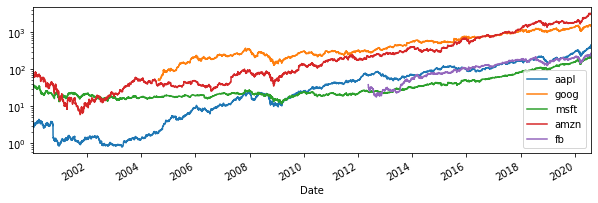

In [21]:
from pandas_datareader import data
stock_tickers = ['aapl', 'goog', 'msft', 'amzn', 'fb']
def load_stock(s):
    return data.DataReader(s, data_source='yahoo', start='2000')['Adj Close']
stock_dfs = {s:load_stock(s) for s in stocks} # dictionary of all stock price
stock_df = pd.concat(stock_dfs, axis=1) # horizontal join
stock_df.plot(logy=True, figsize=(10,3))

# Split-apply-combine 

## A definition
*What is the split-apply-combine framework?*

A procedure to 
1. **split** a DataFrame into subsets of data
2. **apply** certain functions (sorting, mean, other custom stuff)
3. **combine** it back into a DataFrame

Application example: compute mean personal income.

## The process - an overview

How do we *split* observations by x and *apply* the calculation mean of y?*

<center><img src='https://raw.githubusercontent.com/abjer/sds2017/master/slides/figures/split-apply-combine.png'></center>

## Split-apply-combine in pandas

A powerful tool in DataFrames is the `groupby` method. Example:

In [4]:
split_var = 'sex' # like x in figure
apply_var = 'total_bill' # like y in figure

tips.groupby(split_var)[apply_var].mean()

sex
Male      20.744076
Female    18.056897
Name: total_bill, dtype: float64

## What is groupby?
`groupby` creats a collection of sub-dataframes we can process.

We can iterate over a groupby object. Example:

In [27]:
results = {}

for group, group_df in tips.groupby('sex'):
      results[group] = group_df.total_bill.mean() 
    

pd.Series(results)

Male      20.744076
Female    18.056897
dtype: float64

## Other methods and functions in groupby

Can other functions be applied?

- Yes: `mean`, `std`, `min`, `max` all work. 
- Using `.apply()` method and inserting your ***homemade*** function works too.

## Additional variables groupby
Does `groupby` work for multiple variables, functions?

In [6]:
split_vars = ['sex', 'time'] 
apply_vars = ['total_bill', 'tip']
apply_fcts = ['mean', 'std', 'median']
combined = tips.groupby(split_vars)[apply_vars].agg(apply_fcts)

print(combined.reset_index() )   

      sex    time total_bill                        tip                 
                        mean       std median      mean       std median
0    Male   Lunch  18.048485  7.953435  16.58  2.882121  1.329017   2.31
1    Male  Dinner  21.461452  9.460974  19.63  3.144839  1.529116   3.00
2  Female   Lunch  16.339143  7.500803  13.42  2.582857  1.075108   2.01
3  Female  Dinner  19.213077  8.202085  17.19  3.002115  1.193483   3.00


Note grouping with multiple variables uses a [MultiIndex](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.MultiIndex.html) which we do not cover.

## Maintaining the structure
*How do we get our `groupby` output into the original dataframe?*

- Option 1: you use `transform`.

- Option 2: you merge it (not recommended)



In [37]:
mu_sex = tips.groupby(split_var)[apply_var].transform('mean')
(tips.total_bill - mu_sex)

0      -1.066897
1     -10.404076
2       0.265924
3       2.935924
4       6.533103
         ...    
239     8.285924
240     9.123103
241     1.925924
242    -2.924076
243     0.723103
Name: total_bill, Length: 244, dtype: float64

# Reshaping data

## Stacking data

A DataFrame can be collapsed into a Series with the **stack** command:

In [32]:
df = pd.DataFrame([[1,2],[3,4]],columns=['EU','US'],index=[2000,2010])
print(df, '\n')
stacked = df.stack() # going from wide to long format 
stacked =stacked.reset_index()
stacked.columns = ['year', 'place', 'value']
print(stacked)

      EU  US
2000   1   2
2010   3   4 

   year place  value
0  2000    EU      1
1  2000    US      2
2  2010    EU      3
3  2010    US      4


Note: The stacked DataFrame is in long/tidy format, the original is wide.

## To wide format

Likewise we can transform a long DataFrame with the unstack

In [3]:
print(df.stack())
print()
print(df.stack().unstack(level=1))

2000  EU    1
      US    2
2010  EU    3
      US    4
dtype: int64

      EU  US
2000   1   2
2010   3   4


## More stuff

Other cool functions include
- `melt` which only stacks certain columns
- `pivot` which makes you to reshape the dataframe like in Excel

# Summary

1. [joining datasets](#Joining-data)
    - horizontal (columns or index) and vertical
1. [the split apply combine framework](#Split-apply-combine)
    - useful for computing on subsets of data (e.g. mean by type, date)
1. [reshaping data](#Reshaping-data)
    - going from wide to long and back

## Beyond pandas

If you want more sophisticated data processing tools for big data. 

Single machine
- `multiprocessing` and `joblib` for executing code in parallel (using multiple cores)

Multiple machines (cluster)
- `dask` uses a pandas like syntax, also useful for parallelizing
- `pyspark` is Python based but uses a  (multiple machines)
